In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from operator import itemgetter
import numpy as np
import time

In [2]:
os.listdir('./work_dirs/work_dirs_external')

['libra20200109',
 'libra_20200113',
 'libra_20200113_2',
 'libra_20200112',
 'libra_20200112_2',
 'libra_20200109_2',
 'libra_20200110',
 'libra_20200110_2']

In [3]:


path = './data/data_external/val2020_4d'
im_name = 'oct19_103MEDIA_DJI_0592.npy'
im = np.load(os.path.join(path, im_name))
#im = cv2.imread( os.path.join(path, im_name) )
#im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [4]:
config_file = 'configs/libra_rcnn/06_libra_faster_rcnn_x101_64x4d_fpn_1x-SAU_4d_gislyf.py'
checkpoint_file = './work_dirs/work_dirs_external/libra_20200110_2/epoch_4.pth'

model = init_detector(config_file, checkpoint_file, device='cuda:0')


In [5]:
confidence_T = 0.0

In [6]:
def get_labels(result):
    labels = []
    results_good =[]
    for r in result[0]:
        minx, miny, maxx, maxy = list(map( lambda i: int(i),r[:-1]))            
        labels.append({'sheep_color': 'white',
                        'geometry':[[minx, miny],[maxx, maxy]],
                       'confidence': r[-1]
                          })
    return labels

def show_im_with_boxes_not_saved(im, labels, save_to_filename = False):
    fig,ax = plt.subplots(1, figsize=(20, 20))
    ax.imshow(im)    
    
    for l in labels:
        geom = l['geometry']
        
        xmin, ymin = geom[0]
        xmax, ymax = geom[1]
        w = xmax - xmin
        h = ymax - ymin
        rect = patches.Rectangle((xmin,ymin),w,h,linewidth=4,edgecolor='#92d050',facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin,ymin, round(l['confidence'], 3), c='red', fontsize=18 )
    if save_to_filename:
        plt.savefig(save_to_filename)
    plt.draw()
    plt.show()

Show inference for full image:

Split 3040

In [7]:
print(im.shape[:2])

(2336, 3200)


In [8]:
h, w = im.shape[:2]

In [9]:
im_overlap = 512

def get_minxys(h, w, h_new, w_new):
    pos = 0
    minxs = []
    while pos < w - w_new:
        minxs.append(int(pos))
        pos = pos + w_new - im_overlap
    minxs.append(int(w-w_new))

    pos = 0
    minys = []
    while pos < h - h_new:
        minys.append(int(pos))
        pos = pos + h_new - im_overlap
    minys.append(int(h-h_new))
    
    return minxs, minys

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
def is_edge_sheep(box, h, w, h_new, w_new, posx, posy):
    D=20
    xmin, ymin = box[0]
    xmax, ymax = box[1]
    
    if(xmin < D and posx > 0):
        return True
    if(ymin < D and posy > 0):
        return True
    if(w_new - xmax < D and posx < w - w_new):
        return True
    if(h_new - ymax < D and posy < h - h_new):
        return True
    
    return False


def tranform_box_to_full_im_coords(label, posx, posy):
        box = label['geometry']
        xmin, ymin = box[0]
        xmax, ymax = box[1]
        
        new_xmin = xmin + posx
        new_xmax = xmax + posx
        new_ymin = ymin + posy
        new_ymax = ymax + posy
        
        label['geometry'] = [ [new_xmin, new_ymin], [new_xmax, new_ymax]  ]
        
        return label

    
def iou(geom1, geom2):
    xmin1, ymin1 = geom1[0]
    xmax1, ymax1 = geom1[1]
    xmin2, ymin2 = geom2[0]
    xmax2, ymax2 = geom2[1]
    
    A1 = (xmax1 - xmin1)*(ymax1-ymin1)
    A2 = (xmax2 - xmin2)*(ymax2-ymin2)
    
    dx_inter = min(xmax1,xmax2) - max(xmin1, xmin2)
    dy_inter = min(ymax1, ymax2) - max(ymin1, ymin2)
    A_inter=0
    if (dx_inter > 0) and (dy_inter > 0 ):
        A_inter = dx_inter*dy_inter
    
    A_union = A1 + A2 - A_inter
    
    if A_union == 0:
        return 0
    
    return A_inter / A_union


def remove_duplicate_labels(labels):
    
    if(len(labels) <= 1):
        return labels
    
    ok_labels = []
    skip_indices = set()
    
    for i in range(len(labels) - 1):
        if not i in skip_indices:
            geom1 = labels[i]['geometry']
            duplicate_indices = [i]
            for j in range(i +1 , len(labels)):
                if not j in skip_indices:
                    geom2 = labels[j]['geometry']
                    if iou(geom1, geom2) > 0.5:

                        duplicate_indices.append(j)
                        skip_indices.update([i,j])

            #WE DONT WANT MEAN OF OVERLAPPING BOXES. WANT THE ONE WITH MAX CONF (i)
            #if(len(duplicate_indices) > 1):
            #    geoms = list(map( lambda i: labels[i]['geometry'] , duplicate_indices))
            #    geoms = np.asarray(geoms)
            #    new_g = np.mean(geoms, axis = 0)
            #    labels[i]['geometry'] = new_g
                
            ok_labels.append(labels[i])
    
    if(not len(labels) - 1 in skip_indices):
        ok_labels.append(labels[len(labels) - 1])
        
    return ok_labels        

In [12]:
def get_full_im_labels_by_classifying_split_im(h_new, w_new, im=im):
    minxs, minys = get_minxys(h, w, h_new, w_new) 
    Full_im_labels = []

    #Predict for split im. Transform to full im coordinates.
    for minx in minxs:
        for miny in minys:
            part_im = im[miny:miny+h_new, minx: minx + w_new,:]
            result = inference_detector(model, part_im)
            labels = get_labels(result)
            labels = list(filter( lambda l: l['confidence'] > confidence_T ,labels))
            #Dont include sheep on edges (have overlap anyways)       
            labels = list(filter( lambda box: not is_edge_sheep(box['geometry'],h, w, h_new, w_new, minx, miny) ,labels))        

            if len(labels) > 0:
                labels = list(map( lambda l: tranform_box_to_full_im_coords(l, minx, miny) , labels))
                Full_im_labels = [*Full_im_labels, *labels]
                
    #none maximum supression
    Full_im_labels = sorted(Full_im_labels, key=itemgetter('confidence'), reverse=True)
    Full_im_labels = remove_duplicate_labels(Full_im_labels)
    
    return Full_im_labels

## Full image
start = time.time()
result = inference_detector(model, os.path.join(path, im_name))
labels = get_labels(result)
labels = list(filter( lambda l: l['confidence'] > confidence_T ,labels))
labels = sorted(labels, key=itemgetter('confidence'), reverse=True)
labels0 = remove_duplicate_labels(labels)
end = time.time()
print(end - start)
show_im_with_boxes_not_saved(im, labels0)

h_new = w_new  = 3040
labels1 = get_full_im_labels_by_classifying_split_im(h_new, w_new)
#show_im_with_boxes_not_saved(im, labels1)         

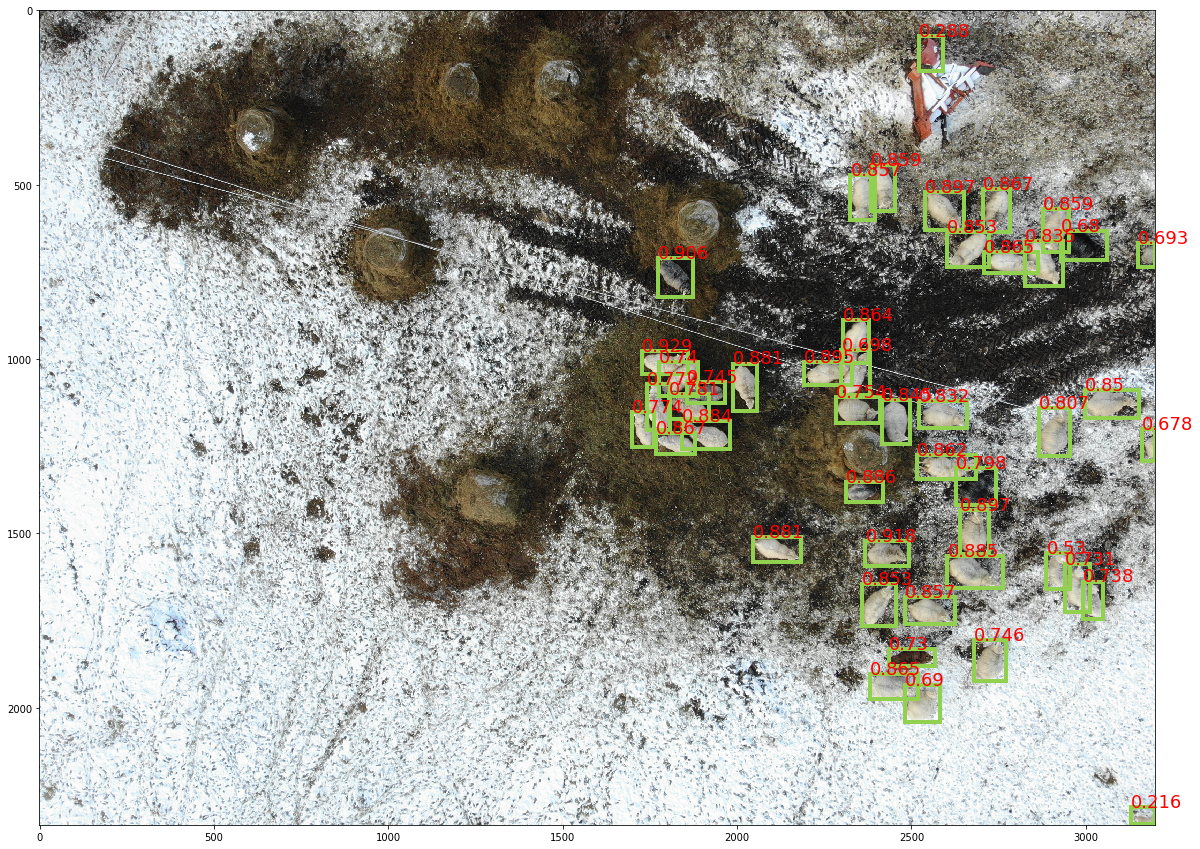

In [22]:
h_new = w_new  = 1024
labels2 = get_full_im_labels_by_classifying_split_im(h_new, w_new)
labels2 = list(filter( lambda l: l['confidence'] > 0.2 ,labels2))
show_im_with_boxes_not_saved(im[:,:,:3], labels2) 

In [13]:
labels2

NameError: name 'labels2' is not defined

## Use boxes from all:
all_labels = [*labels0, *labels1, *labels2]
all_labels = sorted(all_labels, key=itemgetter('confidence'), reverse=True)
all_labels = remove_duplicate_labels(all_labels)
show_im_with_boxes_not_saved(im, all_labels) 

img_path = 'data/sau/Val'
label_map_wth_split = np.load(os.path.join(img_path, '01_valpred_split_libra_20191205_0_epoch_6.npy'), allow_pickle = True).item()
label_map_no_split = np.load(os.path.join(img_path, '01_valpred_nosplit_libra_20191205_0_epoch_6.npy'), allow_pickle = True).item()

In [15]:
img_path = './data/data_external/val2020_4d'
label_map_name = '03_libra20200110_2_epoch4_pred.npy'

#np.save( os.path.join(img_path, label_map_name), {} ) 
label_map = np.load(os.path.join(img_path, label_map_name), allow_pickle = True).item()

i = 0

for path in os.listdir(img_path):
    if 'MEDIA' in path and not '00_labels' in path:
        
        i = i + 1
        print(i)
        
        if not path in label_map.keys():
            label_map = np.load(os.path.join(img_path, label_map_name), allow_pickle = True).item()
            start = time.time()
            print(path)
            if '.npy' in path:
                im = np.load(os.path.join(img_path, path))
            else:
                im = cv2.imread( os.path.join(img_path, path) )
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #labels_full = get_full_im_labels_by_classifying_split_im(3040, 4056, im=im)
            #labels_3040 = get_full_im_labels_by_classifying_split_im(3040, 3040, im=im)
            labels_1024 = get_full_im_labels_by_classifying_split_im(1024, 1024, im=im)

            #all_labels = [*labels_full, *labels_3040, *labels_1024]
            #all_labels = sorted(all_labels, key=itemgetter('confidence'), reverse=True)
            #all_labels = remove_duplicate_labels(all_labels)

            label_map[path] = {'labels' : labels_1024}

            end = time.time()
            print(i, end - start)

            np.save( os.path.join(img_path, label_map_name), label_map ) 


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
oct19_103MEDIA_DJI_0590.npy
33 23.51921582221985
34
sep19_102MEDIA_DJI_0391.npy
34 23.495418310165405
35
sep19_102MEDIA_DJI_0143.npy
35 23.506089210510254
36
aug19_100MEDIA_DJI_0748.npy
36 23.510385751724243
37
sep19_102MEDIA_DJI_0367.npy
37 23.50333881378174
38
sep19_102MEDIA_DJI_0203.npy
38 23.58363437652588
39
sep19_102MEDIA_DJI_0247.npy
39 23.57590961456299
40
sep19_102MEDIA_DJI_0401.npy
40 23.61215043067932
41
sep19_102MEDIA_DJI_0379.npy
41 23.58583164215088
42
sep19_102MEDIA_DJI_0299.npy
42 23.57604694366455
43
sep19_102MEDIA_DJI_0363.npy
43 23.572123765945435
44
sep19_102MEDIA_DJI_0165.npy
44 23.5811665058136
45
sep19_102MEDIA_DJI_0151.npy
45 23.595021963119507
46
sep19_102MEDIA_DJI_0265.npy
46 23.563682794570923
47
sep19_102MEDIA_DJI_0235.npy
47 23.575504779815674
48
sep19_102MEDIA_DJI_0383.npy
48 23.582858085632324
49
sep19_102MEDIA_DJI_0315.npy
49 23.571423292160034
50
sep19_102MEDIA_DJI